In [1]:
#@title Install libraries
!pip install -qU googledrivedownloader silence-tensorflow
!pip install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp36-cp36m-linux_x86_64.whl

!pip install -qU imgaug==0.2.6
!pip install -qU opencv-contrib-python
!pip install -qU scikit-image
!pip install -qU imutils

     |████████████████████████████████| 1.9MB 36.4MB/s 
     |████████████████████████████████| 634kB 2.7MB/s 
     |████████████████████████████████| 49.9MB 71kB/s 
     |████████████████████████████████| 12.4MB 342kB/s 


In [1]:
import os
import shutil
import pandas as pd
import silence_tensorflow
import matplotlib.pyplot as plt
import tensorflow as tf
from tflite_runtime.interpreter import Interpreter
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from sklearn.model_selection import train_test_split

In [2]:
#@title Download dataset

from google_drive_downloader import GoogleDriveDownloader as gdd

# https://drive.google.com/file/d/1wfBL7YGEeMNcJz0p5lljQvr5VmZJuxGe/view?usp=sharing
gdd.download_file_from_google_drive(file_id='1wfBL7YGEeMNcJz0p5lljQvr5VmZJuxGe',
                                    dest_path=f'/content/traffic.zip',
                                    unzip=True)

os.remove('traffic.zip')

Unzipping...Done.


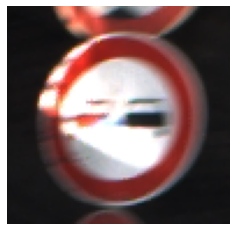

In [3]:
#@title show random image
FILE = np.random.choice(os.listdir('/content/gtsrb-german-traffic-sign/Test'))
img= mpimg.imread(os.path.join('/content/gtsrb-german-traffic-sign/Test', FILE))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show() 

In [4]:
#@title Rectify labels
train_data = pd.read_csv('/content/gtsrb-german-traffic-sign/Train.csv')
print("TRAIN")
print(train_data.ClassId.value_counts())

test_data = pd.read_csv('/content/gtsrb-german-traffic-sign/Test.csv')
test_data.ClassId = test_data.ClassId.replace(list(range(9, 43)), 9)
test_data.to_csv('/content/gtsrb-german-traffic-sign/Test.csv', index=False)
test_data = pd.read_csv('/content/gtsrb-german-traffic-sign/Test.csv')

print()
print("TEST")
print(test_data.ClassId.unique())
print(test_data.ClassId.value_counts())

TRAIN
2    2250
1    2220
4    1980
5    1860
9    1632
7    1440
3    1410
8    1410
6     420
0     210
Name: ClassId, dtype: int64

TEST
[9 4 2 3 7 8 1 5 6 0]
9    2257
1     196
2     189
4     175
5     157
3     146
7     131
8     126
6      35
0      19
Name: ClassId, dtype: int64


In [23]:
DATASET_PATH = '/content/gtsrb-german-traffic-sign/'
TRAIN = os.path.join(DATASET_PATH, 'Train')
TEST = os.path.join(DATASET_PATH, 'Test')

Train_CSV = pd.read_csv(os.path.join(DATASET_PATH, 'Train.csv'))
Test_CSV = pd.read_csv(os.path.join(DATASET_PATH, 'Test.csv'))

labelNames = open("/content/gtsrb-german-traffic-sign/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

print(TRAIN)
print(TEST)
print(labelNames)
# print(Train_CSV)
Test_CSV.head()

/content/gtsrb-german-traffic-sign/Train
/content/gtsrb-german-traffic-sign/Test
['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'not speed']


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,46,46,6,6,40,40,9,Test/03008.png
1,43,45,5,5,38,40,9,Test/06882.png
2,36,43,5,5,31,38,9,Test/11638.png
3,71,67,6,6,65,61,9,Test/09831.png
4,36,33,5,5,30,28,9,Test/06974.png


# Load Training and Testing dataset

In [6]:
# function to read and resize images, get labels and store them into np array

def get_image_label_resize(label, filelist, dim = (32, 32), dataset = 'Train'):
    x = np.array([cv2.resize(cv2.imread(fname), dim, interpolation = cv2.INTER_AREA) for fname in filelist])
    y = np.array([label] * len(filelist))
        
    print('{} examples loaded for label {}'.format(x.shape[0], label))
    return (x, y)    
    
# data for label 0. I store them in parent level so that they won't be uploaded to github
filelist = glob.glob(f'{TRAIN}/0/*.png')
X_train, y_train = get_image_label_resize(0, glob.glob(f'{TRAIN}/'+str(0)+'//*.png'))

210 examples loaded for label 0


In [7]:
# go through all others labels and store images into np array
for label in Train_CSV.ClassId.unique()[1:]:
    # print(label)
    filelist = glob.glob(f'{TRAIN}/{label}/*.png')
    x, y = get_image_label_resize(label, filelist)
    X_train = np.concatenate((X_train ,x))
    y_train = np.concatenate((y_train ,y))

2220 examples loaded for label 1
2250 examples loaded for label 2
1410 examples loaded for label 3
1980 examples loaded for label 4
1860 examples loaded for label 5
420 examples loaded for label 6
1440 examples loaded for label 7
1410 examples loaded for label 8
1632 examples loaded for label 9


In [8]:
# get path for test images
testfile = Test_CSV['Path'].apply(lambda x: f'{DATASET_PATH}' + x).tolist()
# print(testfile[0])
X_test = np.array([cv2.resize(cv2.imread(fname), (32, 32), interpolation = cv2.INTER_AREA) for fname in testfile])
y_test = np.array(Test_CSV['ClassId'])

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14832, 32, 32, 3) (14832,)
(3431, 32, 32, 3) (3431,)


In [10]:
#@title split in train and validation set

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                test_size=0.2, 
                                                                stratify=y_train,
                                                                random_state=42)

In [11]:
#@title get overall stat of the whole dataset
n_train = X_train.shape[0]
n_validation = X_validation.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("There are {} training examples ".format(n_train))
print("There are {} validation examples".format(n_validation))
print("There are {} testing examples".format(n_test))
print("Image data shape is {}".format(image_shape))
print("There are {} classes".format(n_classes))

There are 11865 training examples 
There are 2967 validation examples
There are 3431 testing examples
Image data shape is (32, 32, 3)
There are 10 classes


# Preprocess

In [12]:
# convert the images to grayscale

X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)
X_validation_gry = np.sum(X_validation/3, axis=3, keepdims=True)
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

# Normalize data
X_train_normalized_gry = (X_train_gry-128)/128
X_validation_normalized_gry = (X_validation_gry-128)/128
X_test_normalized_gry = (X_test_gry-128)/128

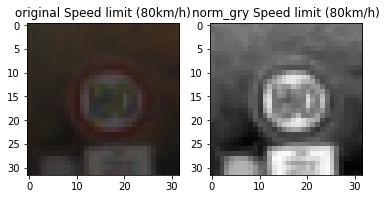

In [14]:
%matplotlib inline

plt.style.use('seaborn-colorblind')

# descriptions for each label
sign = pd.read_csv('/content/gtsrb-german-traffic-sign/signnames.csv')

# pick an image, display the original and the normalized gray image
index = np.random.randint(0, n_train)
fig, ax = plt.subplots(1,2)
ax[0].set_title('original ' + sign.loc[sign['ClassId'] ==y_train[index], 'SignName'].values[0])
ax[0].imshow(cv2.cvtColor(X_train[index], cv2.COLOR_BGR2RGB))

ax[1].set_title('norm_gry ' + sign.loc[sign['ClassId'] ==y_train[index], 'SignName'].values[0])
_=ax[1].imshow(X_train_normalized_gry[index].squeeze(), cmap='gray')

In [15]:
# update the train, val and test data with normalized gray images
X_train = X_train_normalized_gry
X_validation = X_validation_normalized_gry
X_test = X_test_normalized_gry

In [16]:
NUM_EPOCHS = 20
batch_size = 64

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest"
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

checkpoint_filepath = '/content/speed_limit_best'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(filters = 6, kernel_size = (5, 5), strides=(1, 1), padding='valid', 
                        activation='relu', data_format = 'channels_last', input_shape = (32, 32, 1)))
# Maxpool 28x28x6 => 14x14x6
model.add(layers.MaxPooling2D((2, 2)))
# Conv 14x14x6 => 10x10x16
model.add(layers.Conv2D(16, (5, 5), activation='relu'))
# Maxpool 10x10x16 => 5x5x16
model.add(layers.MaxPooling2D((2, 2)))
# Flatten 5x5x16 => 400
model.add(layers.Flatten())
# Fully connected 400 => 120
model.add(layers.Dense(120, activation='relu'))
# Fully connected 120 => 84
model.add(layers.Dense(84, activation='relu'))
# Dropout
model.add(layers.Dropout(0.2))
# Fully connected, output layer 84 => 43
model.add(layers.Dense(10, activation='softmax'))

In [21]:
# specify optimizer, loss function and metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training batch_size=128, epochs=10
conv = model.fit(train_generator, 
                 batch_size=batch_size, 
                 epochs=NUM_EPOCHS, 
                 validation_data=(X_validation, y_validation),
                 callbacks=[model_checkpoint_callback]
                )

Epoch 1/20
185/186 [============================>.] - ETA: 0s - loss: 1.9950 - accuracy: 0.2393WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/speed_limit_best/assets
186/186 [==============================] - 12s 63ms/step - loss: 1.9945 - accuracy: 0.2392 - val_loss: 1.7743 - val_accuracy: 0.3354
Epoch 2/20
186/186 [==============================] - 12s 63ms/step - loss: 1.7087 - accuracy: 0.3662 - val_loss: 1.3042 - val_accuracy: 0.5713
Epoch 3/20
186/186 [==============================] - 11s 61ms/step - loss: 1.2707 - accuracy: 0.5479 - val_loss: 0.7075 - val_accuracy: 0.7792
Epoch 4/20
186/186 [==============================] - 12s 6

In [22]:
model.evaluate(x=X_test, y=y_test)

108/108 [==============================] - 1s 10ms/step - loss: 0.1941 - accuracy: 0.9525


[0.19409140944480896, 0.9524919986724854]

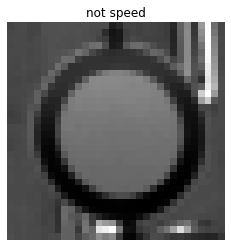

In [31]:
index = np.random.randint(0, n_test)
im = X_test[index]
fig, ax = plt.subplots()
ax.set_title(sign.loc[sign['ClassId'] == np.argmax(model.predict(np.array([im]))), 'SignName'].values[0])
ax.imshow(im.squeeze(), cmap = 'gray')
ax.set_axis_off()

In [32]:
best_model = tf.keras.models.load_model('/content/speed_limit_best')

In [38]:
from imutils import paths
import imutils
import random
from PIL import Image

In [46]:
print("Predicting...")
imagePaths = list(paths.list_images(TEST))[:25]
                  
random.shuffle(imagePaths)
labels = []
images = []

image_ = []
for (i, imagePath) in enumerate(imagePaths):
    
    images.append(imagePath)
    # convert the image to grayscale

    image = cv2.imread(imagePath, 0)
    image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
    # print(image)
    # break
    image = image.astype("float32") / 255.0
    image = image.reshape(32, 32, 1)
    image_.append(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    
    j = preds.argmax(axis=1)[0]
    
    label = labelNames[j]
    labels.append(label)
  
print("Done")

Predicting...
Done


In [47]:
image_ = np.array(image_)
image_.shape
len(labels)

25

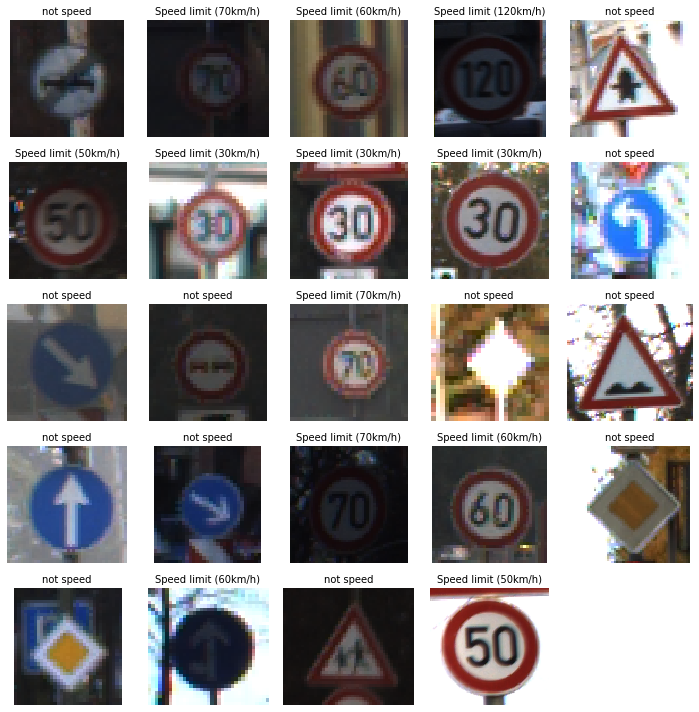

In [55]:
plt.figure(figsize=(10, 10))

imag_index = 0
label_index = 0

for i in range(1, len(images)):
    plt.subplot(5, 5, i)
    
    imag = f"{images[imag_index]}"
    
    plt.imshow(mpimg.imread(imag), interpolation="nearest")

    plt.title(labels[label_index], fontsize= 10)
    imag_index += 1
    label_index += 1
    plt.axis("off")
    plt.tight_layout()

plt.show()

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = []
converter.allow_custom_ops = True
tflite_model = converter.convert()

tf_model_files = f'speed_limit.tflite' 
!rm -rf $tf_model_files
open(tf_model_files, "wb").write(tflite_model)

249484

In [51]:
test_data = Test_CSV.sample(frac=1, random_state=42)
test_data.ClassId.unique()

array([3, 9, 8, 7, 5, 2, 1, 0, 4, 6])

In [52]:
interpreter = tf.lite.Interpreter(model_path=tf_model_files)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
input_index = input_details[0]["index"]
height = input_details[0]["shape"][1]
width = input_details[0]["shape"][2]

output_details = interpreter.get_output_details()
output_index = output_details[0]["index"]
input_index, output_index, height, width

(0, 20, 32, 32)

Label:not speed, Output: not speed


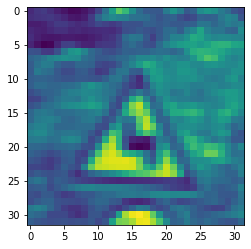

Label:not speed, Output: not speed


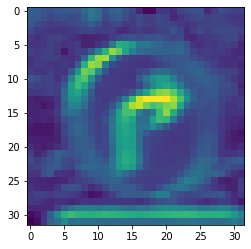

Label:Speed limit (70km/h), Output: not speed


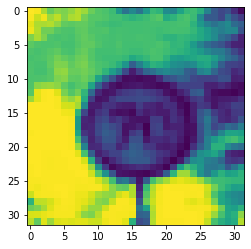

Label:not speed, Output: not speed


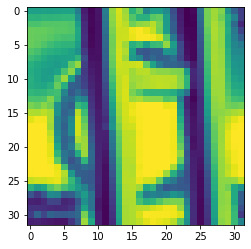

Label:not speed, Output: not speed


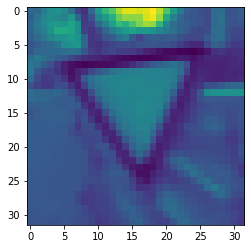

Label:not speed, Output: not speed


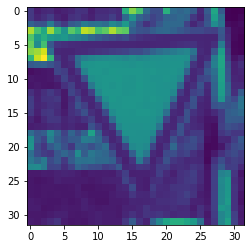

Label:not speed, Output: not speed


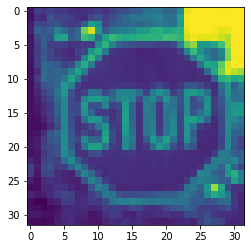

Label:Speed limit (50km/h), Output: Speed limit (50km/h)


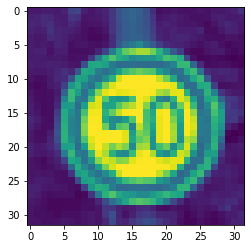

Label:not speed, Output: not speed


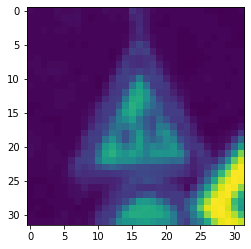

Label:not speed, Output: not speed


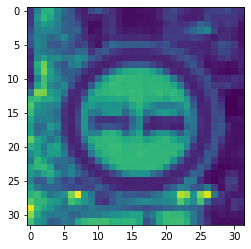

In [62]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_img = [], []

for idx, row in test_data.iterrows():
    if idx < 10:
        imagePath = row['Path'].replace(r'Test/', '/content/gtsrb-german-traffic-sign/Test/')
        label = row['ClassId']
        
        image = cv2.imread(imagePath, 0)
        image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
        image = image.astype("float32") / 255.0
        image = image.reshape(32, 32, 1)
        # print(imagePath, label)
        plt.imshow(image.reshape(32, 32))
        
        interpreter.set_tensor(input_index, np.expand_dims(image, axis=0))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index)
        print(f"Label:{labelNames[label]}, Output: {labelNames[np.argmax(output_data)]}")
        plt.show()  